 #### Reading image category:  Flower  ##### 
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0006.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0007.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0005.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0004.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0001.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0003.jpg
Reading file:  /Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/Flower/0002.jpg
 #### Reading image category:  Ox  ##### 
Reading f

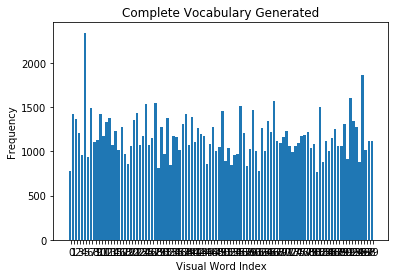

Training SVM
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Train labels [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  3.
  3.  3.  3.  3.  3.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.]
Training completed
End of testing.


In [4]:
import cv2
import numpy as np 
from glob import glob 
import argparse
from helpers import *
from matplotlib import pyplot as plt 


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []

    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path)
        # extract SIFT Features from each image
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print("Computing Features for ", word)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1


        # perform clustering
        bov_descriptor_stack = self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        self.bov_helper.plotHist()
 

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
#         print(des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

#         print(vocab)
        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """

        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)

        predictions = []

        for word, imlist in self.testImages.items():
            print("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
#                 print(im.shape)
                cl = self.recognize(im)
                print(cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

#         print(predictions)
        testfile = 0
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            # 
            testfile += 1
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.savefig('{0}_{1}_prediction.jpg'.format(testfile, each['object_name']), bbox_inches='tight')
            plt.show()
        print("End of testing.")

    def print_vars(self):
        pass


if __name__ == '__main__':

    
    bov = BOV(no_clusters=100)

    # set training paths
    bov.train_path = '/Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/trainpaint/'
    # set testing paths
    bov.test_path = '/Users/Kirsti/Google Drive/BigData/milestone3/Bag-of-Visual-Words-Python-master/images/testpaint/'
    # train the model
    bov.trainModel()
    # test model
    bov.testModel()
